## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/tweet-dataset-split-roberta-base-96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_1.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_2.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_3.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_4.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_5.tar.gz

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/x_valid.npy
fold_2/
fold_2/y_train.npy
fold_2/x_train.npy
fold_2/y_valid.npy
fold_2/x_valid.npy
fold_3/
fold_3/y_train.npy
fold_3/x_train.npy
fold_3/y_valid.npy
fold_3/x_valid.npy
fold_4/
fold_4/y_train.npy
fold_4/x_train.npy
fold_4/y_valid.npy
fold_4/x_valid.npy
fold_5/
fold_5/y_train.npy
fold_5/x_train.npy
fold_5/y_valid.npy
fold_5/x_valid.npy


# Model parameters

In [3]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 5,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 1,
  "question_size": 4,
  "N_FOLDS": 5,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [4]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1.87e-06


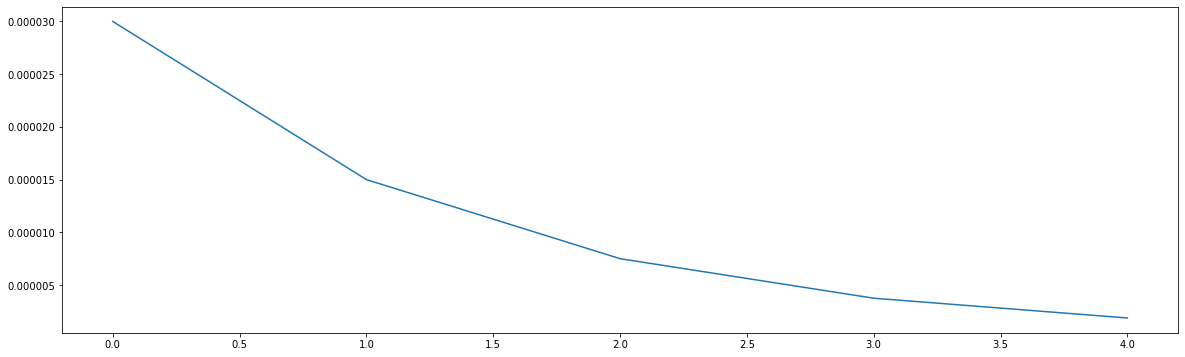

In [5]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
LR_EXP_DECAY = .5

@tf.function
def lrfn(epoch):
    lr = LR_MAX * LR_EXP_DECAY**epoch
    if lr < LR_MIN:
        lr = LR_MIN
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
#     x = layers.Dropout(.1)(last_hidden_state)
    
    x_start = layers.Dense(1)(last_hidden_state)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', dtype='float32', name='y_start')(x_start)

    x_end = layers.Dense(1)(last_hidden_state)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', dtype='float32', name='y_end')(x_end)

    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [7]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn_start(y['y_start'], probabilities[0], label_smoothing=0.2)
                loss_end = loss_fn_end(y['y_end'], probabilities[1], label_smoothing=0.2)
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_acc_start.update_state(y['y_start'], probabilities)
            train_acc_end.update_state(y['y_end'], probabilities)
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn_start(y['y_start'], probabilities[0])
            loss_end = loss_fn_end(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_acc_start.update_state(y['y_start'], probabilities)
            valid_acc_end.update_state(y['y_end'], probabilities)
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size))
    loss_fn_start = losses.categorical_crossentropy
    loss_fn_end = losses.categorical_crossentropy

    train_acc_start = metrics.CategoricalAccuracy()
    valid_acc_start = metrics.CategoricalAccuracy()
    train_acc_end = metrics.CategoricalAccuracy()
    valid_acc_end = metrics.CategoricalAccuracy()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'acc_start': train_acc_start, 'acc_end': train_acc_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end, 
                    'val_acc_start': valid_acc_start, 'val_acc_end': valid_acc_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], model_path)
    
    history_list.append(history)
    model.load_weights(model_path)
    
    # Make predictions
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 687 steps, validate for 171 steps

EPOCH 1/5
time: 281.1s loss: 4.3779 loss_start: 2.1766 loss_end: 2.2013 acc_start: 0.3919 acc_end: 0.3927 val_loss: 2.0467 val_loss_start: 1.0322 val_loss_end: 1.0144 val_acc_start: 0.4102 val_acc_end: 0.3952
Saved model weights at "model_fold_1.h5"

EPOCH 2/5
time: 266.5s loss: 4.0690 loss_start: 2.0260 loss_end: 2.0430 acc_start: 0.4281 acc_end: 0.4200 val_loss: 1.9766 val_loss_start: 1.0027 val_loss_end: 0.9739 val_acc_start: 0.4333 val_acc_end: 0.4320
Saved model weights at "model_fold_1.h5"

EPOCH 3/5
time: 266.7s loss: 3.9525 loss_start: 1.9730 loss_end: 1.9795 acc_start: 0.4393 acc_end: 0.4327 val_loss: 1.9198 val_loss_start: 0.9684 val_loss_end: 0.9514 val_acc_start: 0.4282 val_acc_end: 0.4089
Saved model weights at "model_fold_1.h5"

EPOCH 4/5
time: 266.8s loss: 3.8956 loss_start: 1.9528 loss_end: 1.9428 acc_start: 0.4425 acc_end: 0.4399 val_loss: 1.9223 val_loss_start: 0.9819 val_loss_end: 0.9404 val_acc_start: 0.4294 val_

# Model loss graph

Fold: 1


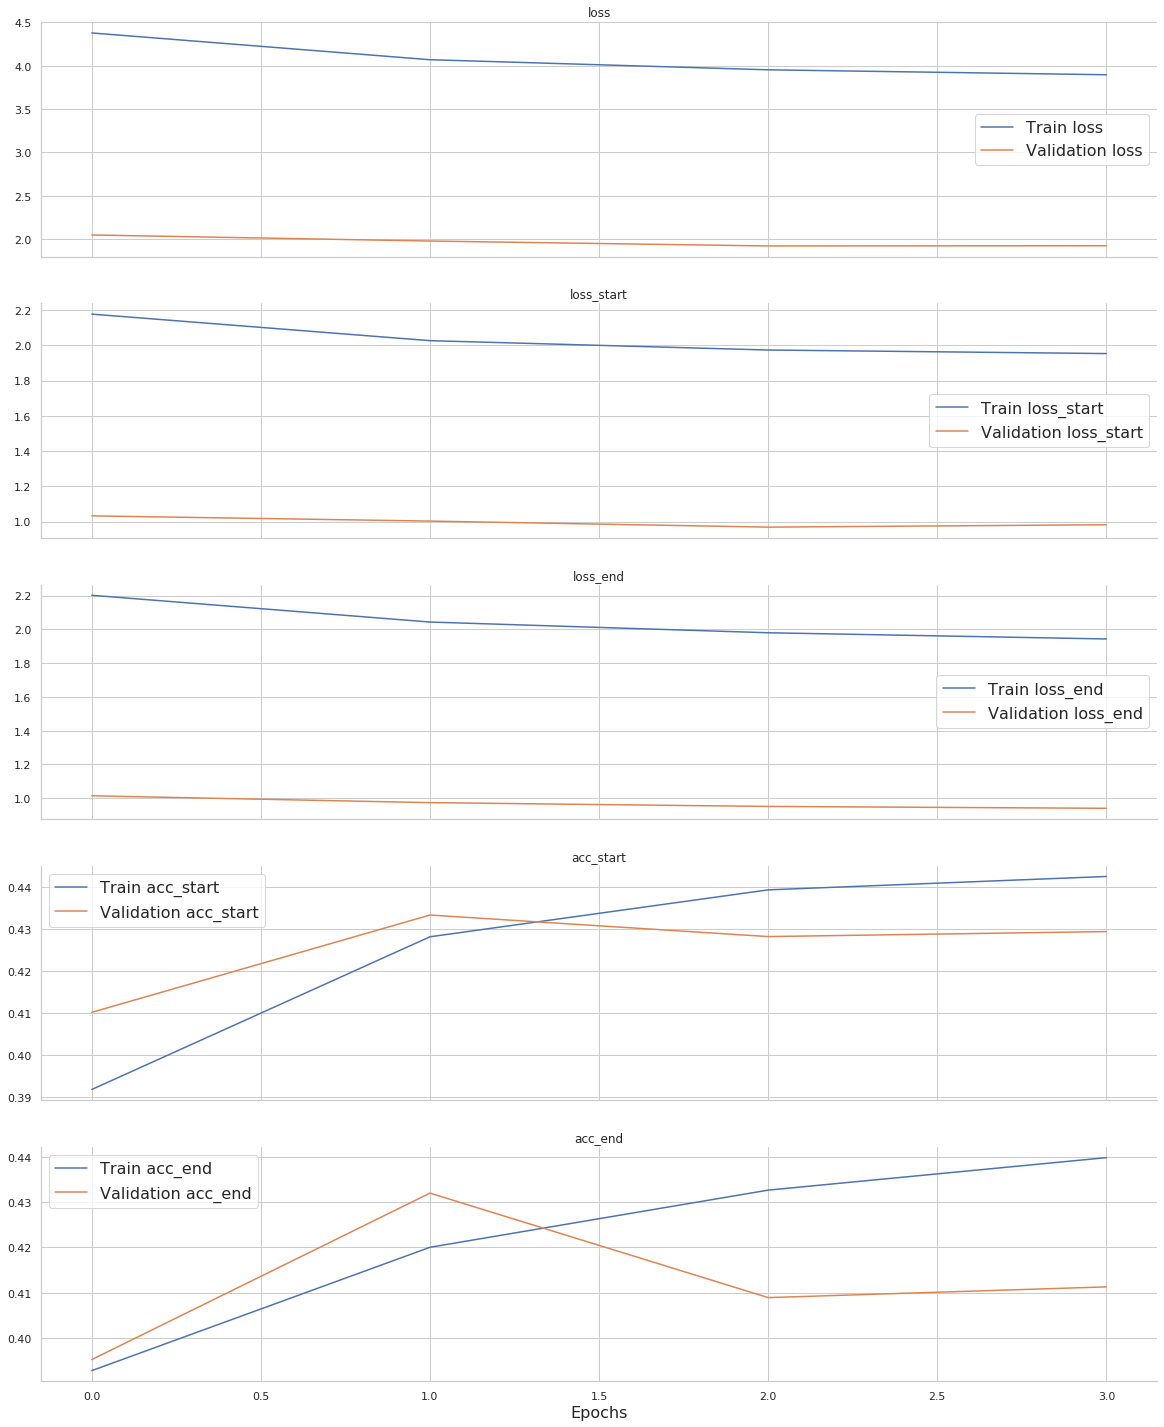

Fold: 2


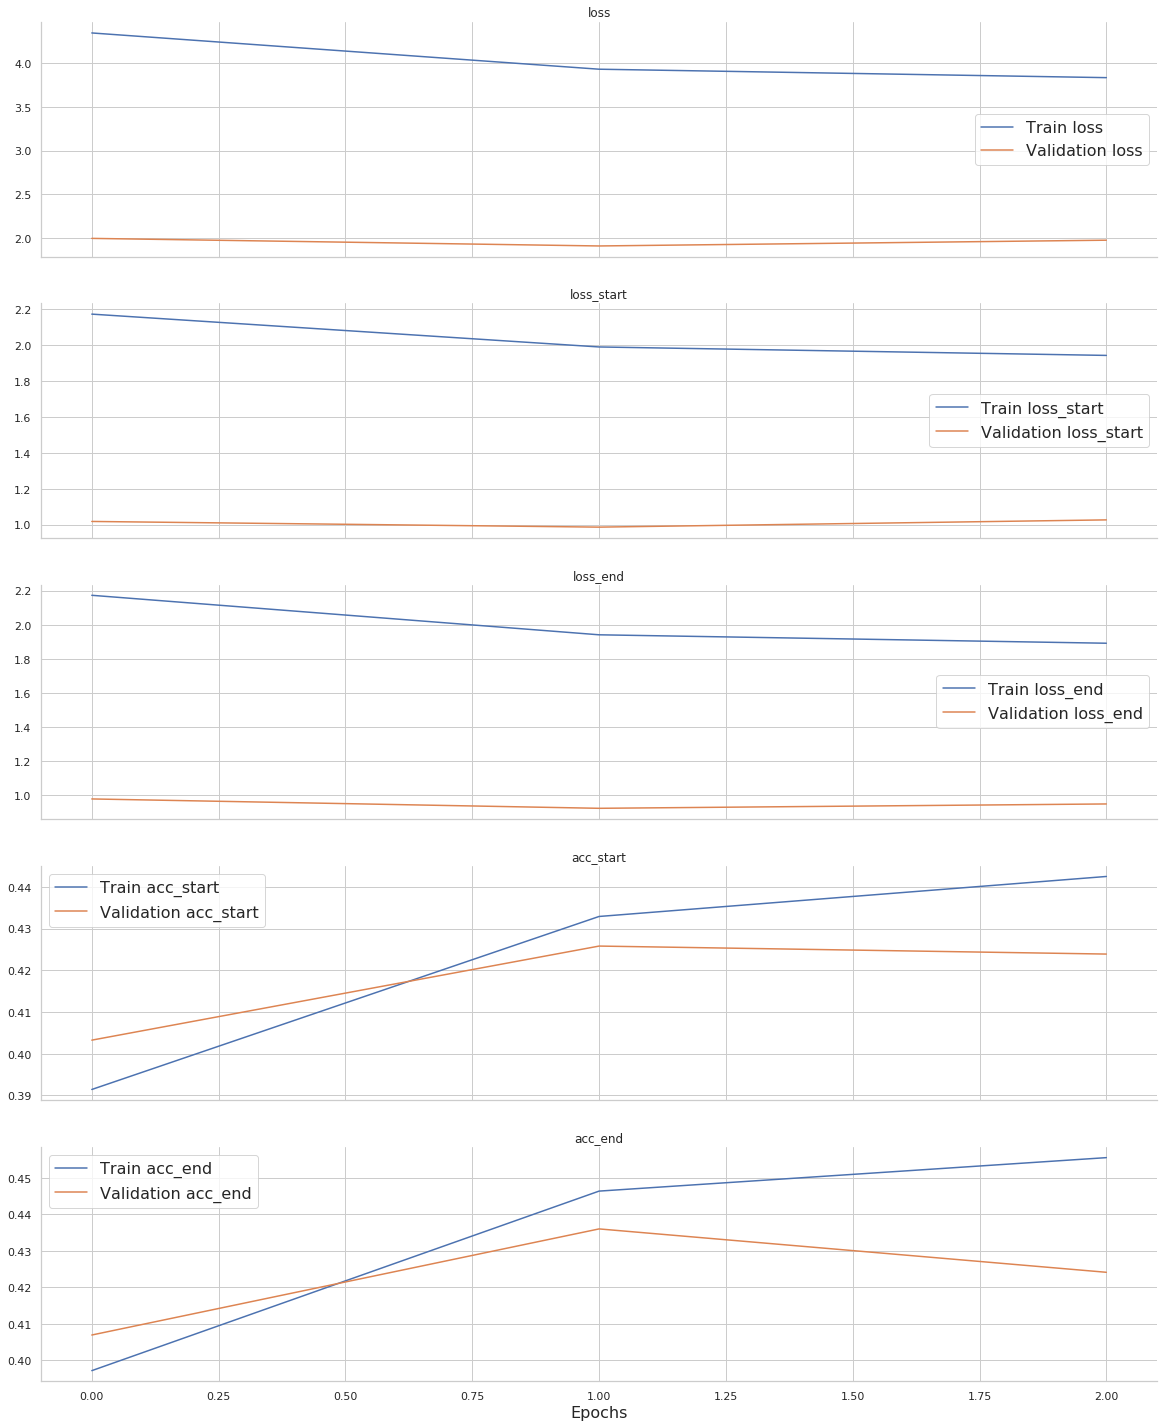

Fold: 3


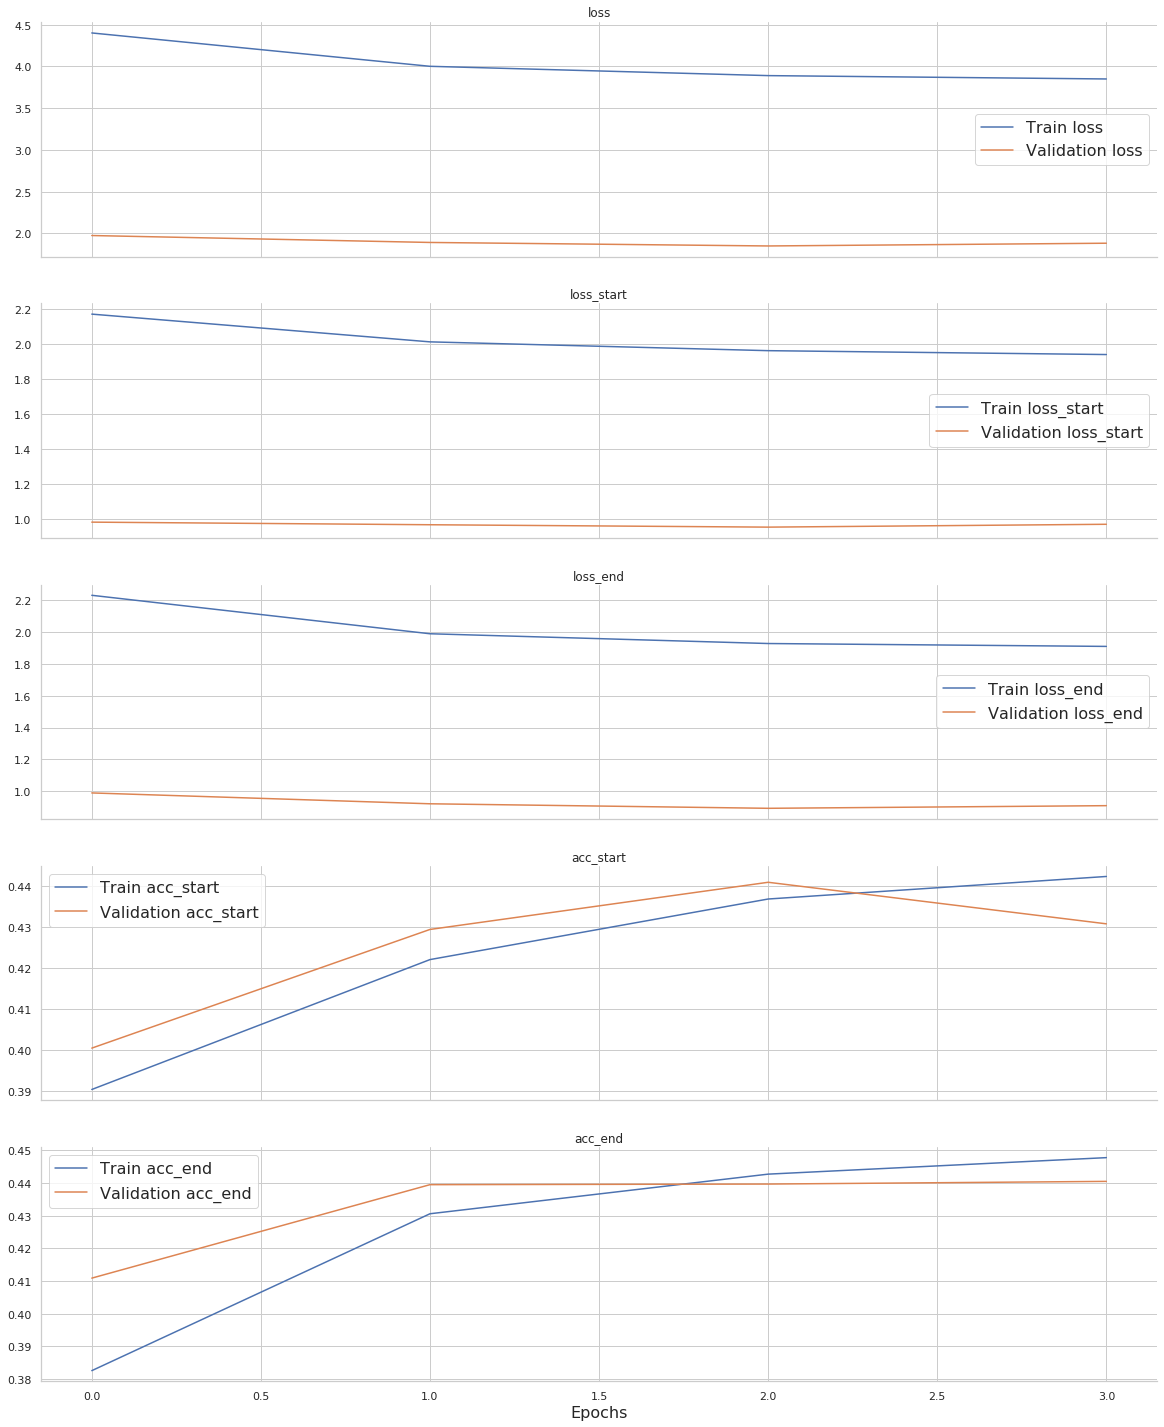

Fold: 4


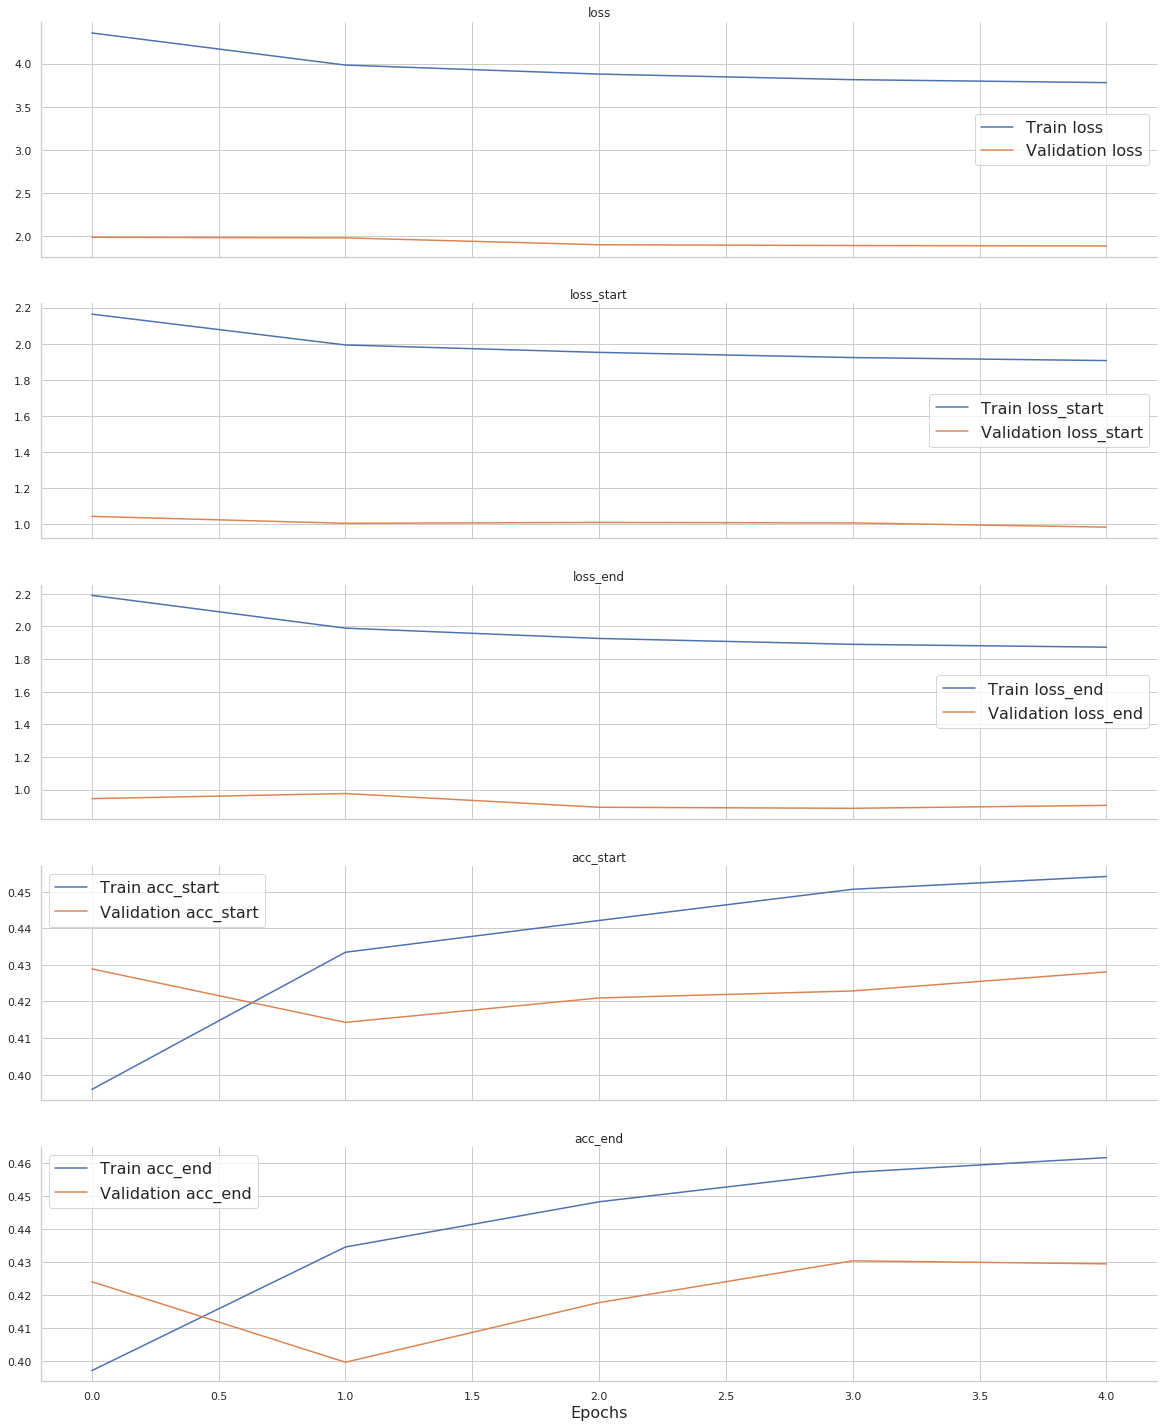

Fold: 5


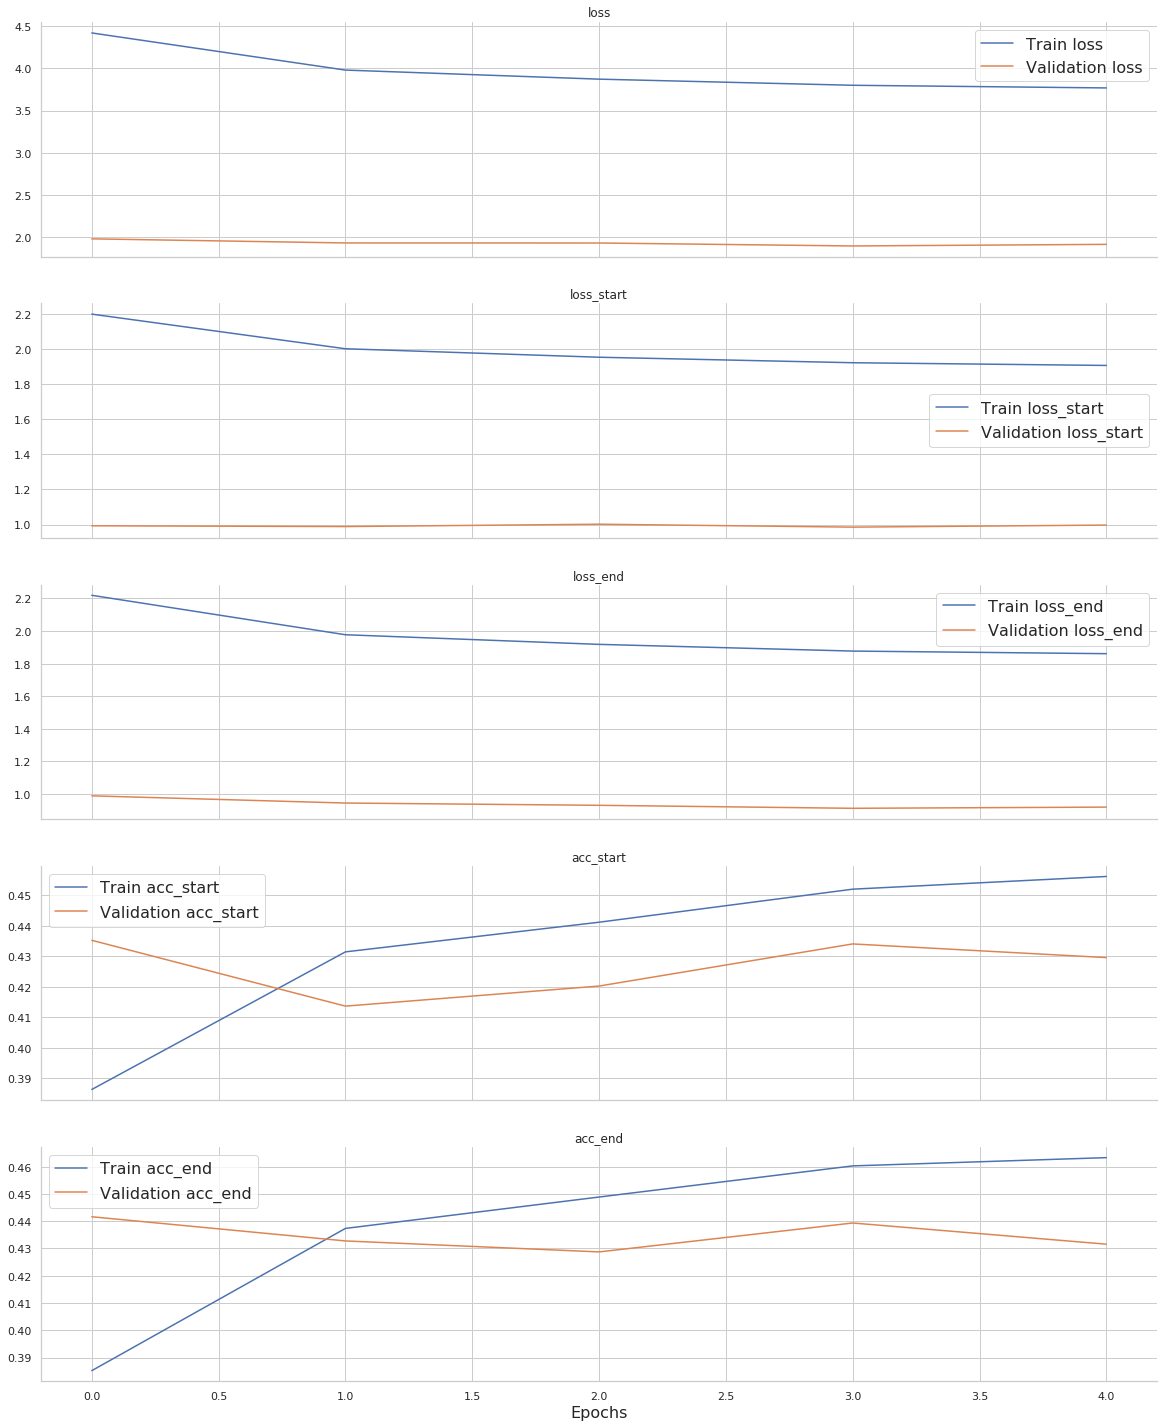

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [9]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.744903,0.702522,0.042381,0.719627,0.685539,0.741228,0.702855,0.736100,0.711053,0.761231,0.702583,0.766330,0.710581
Sentiment negative,0.599470,0.523427,0.076043,0.571567,0.500490,0.589486,0.524912,0.585615,0.535895,0.617844,0.528902,0.632840,0.526937
Sentiment neutral,0.968207,0.966085,0.002122,0.946191,0.942301,0.973225,0.973162,0.971466,0.972404,0.975509,0.969719,0.974645,0.972842
Sentiment positive,0.587497,0.523485,0.064012,0.560412,0.520562,0.578316,0.513880,0.567627,0.531413,0.613640,0.514116,0.617490,0.537456
0 <= text wordCnt < 3,0.863343,0.853186,0.010157,0.865385,0.813433,0.860060,0.863135,0.859816,0.868766,0.868485,0.836538,0.862969,0.884058
3 <= text wordCnt < 10,0.797685,0.767449,0.030237,0.787289,0.750652,0.790261,0.770846,0.789536,0.779142,0.810108,0.758855,0.811233,0.777748
10 <= text wordCnt < 30,0.712681,0.662867,0.049814,0.678738,0.645644,0.710502,0.663192,0.702885,0.671486,0.731960,0.666561,0.739319,0.667451
30 <= text wordCnt < 100,0.676361,0.604504,0.071857,0.636707,0.595804,0.703908,0.519966,0.677259,0.547182,0.680799,0.622869,0.683129,0.736699
0 <= selected text wordCnt < 3,0.681256,0.606695,0.074561,0.645218,0.578945,0.669089,0.604656,0.672395,0.620013,0.708345,0.607949,0.711230,0.621911


# Visualize predictions

In [10]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,sooo sad,1.000000,sad,0.500000,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,"sons of ****,",1.000000,"sons of ****,",1.000000,"****,",0.333333,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,some shameless plugging for the best rangers f...,0.833333,some shameless plugging for the best rangers f...,0.833333
6,2am feedings for the baby are fun when he is a...,fun,positive,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,wow...,0.200000,wow...,0.200000,wow...,0.200000,wow...,0.200000,wow...,0.200000
